# Basic Librosa

Author: Jake Dumbauld <br>
Contact: jacobmilodumbauld@gmail.com<br>
Date: 3.15.22

## Introduction

The purpose of this notebook was to familiarize myself with librosa, as well as create some visualizations of the data that I'm working with for presentation & technical report purposes. 

## Library Imports

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display
import IPython

import os

In [2]:
root_path = '/Users/jmd/Documents/BOOTCAMP/Capstone/'

## File Imports & Loading Signal Data

In [3]:
file = root_path + 'the-circor-digiscope-phonocardiogram-dataset-1.0.1/training_data/2530_AV.wav'

In [4]:
# lets take a listen
IPython.display.Audio(file)

I listened through a number of the audio files in the dataset, and found that this one was illustrative of a key point: there's a fair bit of noise in this data. Heart sounds aren't abundantly clear throughout, and you can clearly hear the rustling of the instrument against the patient's shirt at the end of the clip. At the outset, I realized I had to lower my expectations for the performance of the final models.

In [5]:
signal, sr = librosa.load(file) # signal is the array that contains the amplitude of the waveform at a given point in time.
print(sr)                   # sr is the sampling rate, defaults to 22050 hz.
print(len(signal))          
print(len(signal)/sr)       # .wav file is 23.6 seconds long. 

22050
520380
23.6


For this one .wav file, we have 520380 data points. Multiply this by over 3000 patient files and you end up with QUITE a bit of data. </br>
The sampling rate will become a VERY important topic throughout these notebooks. No spoilers though :). 

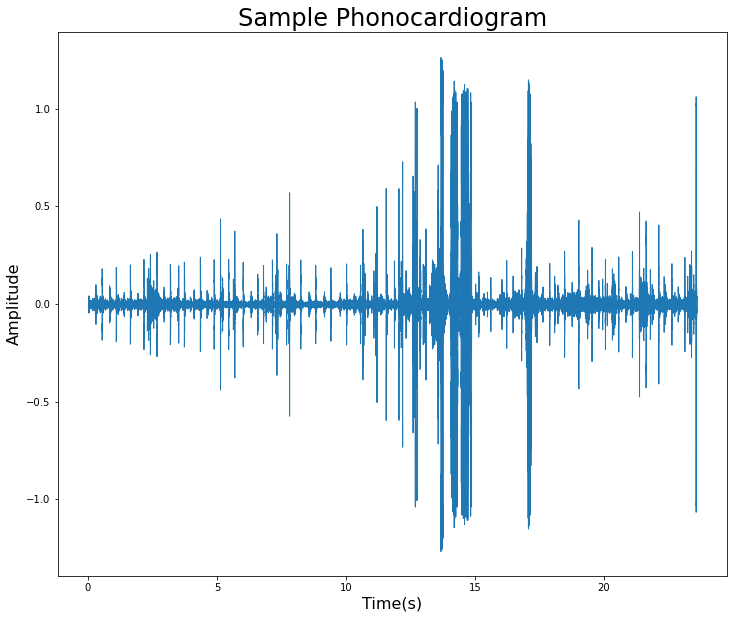

In [6]:
# visualizing the waveform from the imported .wav file.
plt.figure(figsize=(12,10))
librosa.display.waveshow(signal, sr = sr)
plt.ylabel("Amplitude", size=16)
plt.xlabel('Time(s)', size=16)
plt.title('Sample Phonocardiogram', size=24)
plt.savefig(fname=root_path + 'sample_phonocardiogram.png')

Librosa has great built in functions for visualizing audio data. Listen to the audio file above and follow along the graph, time is on the x axis. See if you can match up the rustling of the patients shirt with the amplitude on the graph!

## Signal Transformation

Future models in this project rely on something called Mel Frequency Cepstral Coefficients (MFCCs). Put simply, it is a transformed and binned representation of audio data that approximates the human auditory system's response to sound. It's a fascinating and deep topic, and if you'd like to learn more I'd encourage you to watch Valerio Velardo's youtube series on the topic. Here's a [link](https://www.youtube.com/watch?v=3gzI4Z2OFgY&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=16) to the first video I watched in the series.

The subsequent code cells in this notebook help build up a fundamental understanding of what is going on in this transformation process.</br></br>

The first step is to take the fourier transform of the sound data. Here we use a quick implementation of this built into numpy.

In [7]:
# fast fourier transform, goal of converting it to a spectrum
fft = np.fft.fft(signal) # returns an array of complex numbers
fft

array([-132.58879333 +0.j        ,   48.17535493 +4.90108609j,
         -6.70912643-38.53483667j, ...,  -98.36048657-12.62779976j,
         -6.70912643+38.53483667j,   48.17535493 -4.90108609j])

The returned values are an array of complex numbers, which we break down below.

In [8]:
# now pulling out the magnitude of these values
magnitude = np.abs(fft) # abs of the complex value returned by the fft gives you the magnitude of the frequency
frequency = np.linspace(0,sr, len(magnitude)) # interval we input is between a frequency of 0 hz and our sample rate, performing this over the length of the magnitude array. 

Plotting this out...

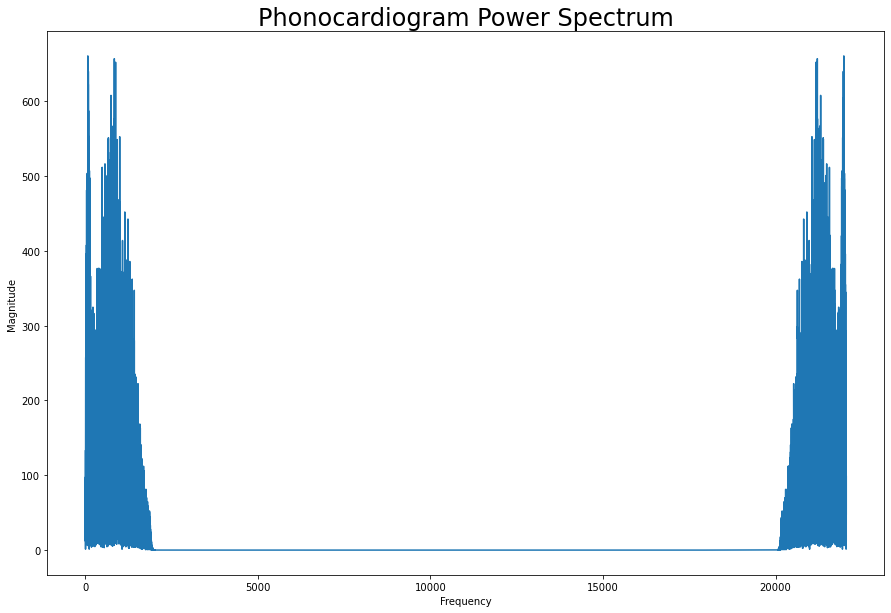

In [9]:
# lets plot our frequencies.
plt.figure(figsize=(15,10))
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title('Phonocardiogram Power Spectrum', size=24)
plt.show()

This plot is symmetric about `sr/2`, so we can discard the right half of the plot and focus on the left to get a better picture of our power spectrum.

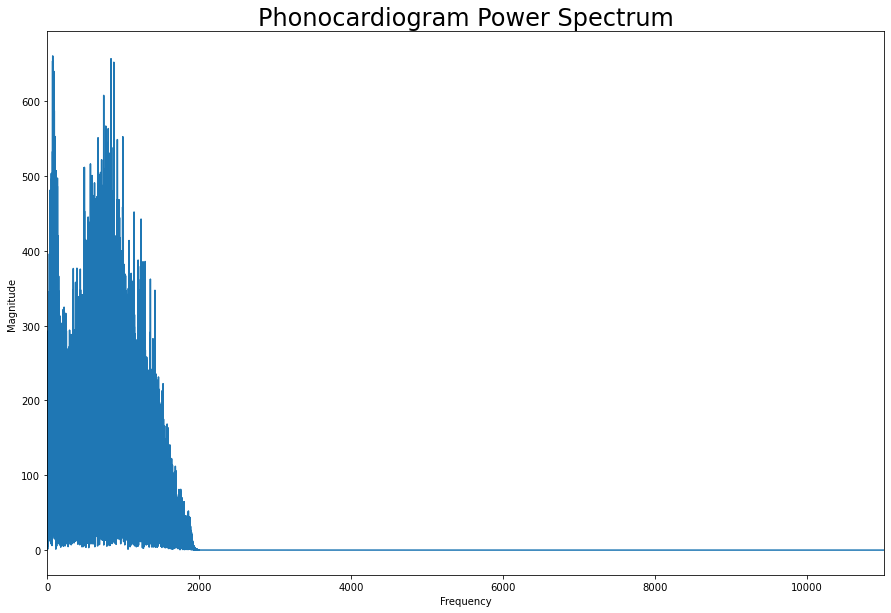

In [10]:
#thus
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

# re-plotting our frequencies.
plt.figure(figsize=(15,10))
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.xlim(0,sr/2)
plt.title('Phonocardiogram Power Spectrum', size=24)
plt.show()

### Intrepretation:

We can see that the frequencies are all below 2k Hz, a value that will become important in later discussions. </br>
However, in this process we've lost the information about the time domain. The x-axis of our data is frequency, and the y is magnitude. Importantly, this figure represents the magnitude of frequencies over the _whole_ of our audiofile, in aggregate.. Since our problem fundamentally relies on the relationship between frequency and time, we need to alter our approach.

## Spectrograms & MFCCs

To do so, we'll apply a short time fourier transform to our data. It's the same process as above, but instead we're snapshotting along the length of our audio data. `n_fft` defines the size of our 'window' that we're snapshotting, and `hop_length` defines how far 'to the right' our window slides along the length of our audio data at each step. Remember, our sampling rate is 22kHz, and we've got ~500k data points in this audiofile with that sampling rate.

In [11]:
n_fft = 1024
hop_length = 256

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

By applying this mathematical magic, we can get data that can be plotted out into a spectrogram. This is a representation of our freqeuncies over _time_ (the domain we lost in the initial fft!), and now color represents magnitude.

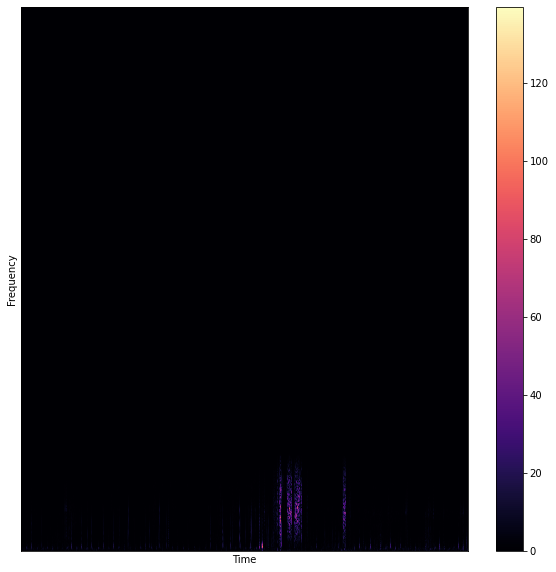

In [12]:
spectrogram = np.abs(stft)

plt.figure(figsize=(10,10))
librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

The magnitude of our frequencies are in units that are unclear. To remedy this, we use the librosa library to transform our magnitude into decibels, a familiar unit for sound intensity.

In [13]:
log_spectrogram = librosa.amplitude_to_db(spectrogram)

Also, the above figure is pretty sparse, but what we can see again is that our frequencies are clustered towards the bottom. Recall in the power spectrum how we noted that our frequencies were all below 2k...Let's zoom in on that space in our spectrogram, and change up the color mapping for a prettier picture!

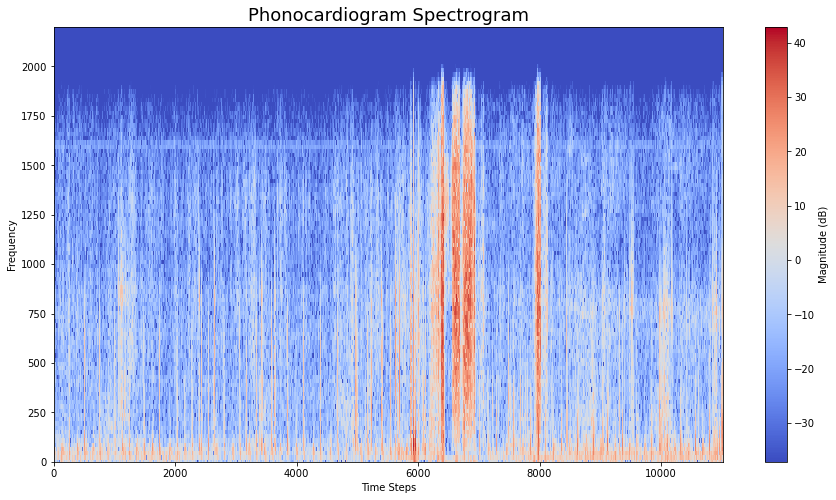

In [19]:
plt.figure(figsize=(15,8))
librosa.display.specshow(log_spectrogram, y_axis='hz', x_axis='linear')
plt.xlabel("Time Steps")
plt.ylabel("Frequency")
plt.ylim(0,2200)
plt.colorbar(label='Magnitude (dB)')
plt.title('Phonocardiogram Spectrogram', size=18)
plt.savefig(fname=root_path + 'sample_spectrogram.png')

The above spectrogram is very granular, showing the frequencies of our data over time. In reality this isn't how you and I would percieve this audio file. So, we'll return to creating our MFCCs.

Using the librosa library we can extract the MFCCs from the signal data. To understand the process under the hood, take a look at the wikipedia article for [Mel-Frequency Cepstrum](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). We're using the same `n_fft` & `hop_length` as above, however there's a new parameter in `n_mfcc`. This is the number of 'bins' that we're separating our frequencies into. In the reading I did, it seemed that 20 is standard, so we'll be proceeding with that.

In [15]:
MFCCs = librosa.feature.mfcc(y=signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=20)
log_MFCCs = librosa.amplitude_to_db(MFCCs)

Again applying the log transformation for decibel magnitude units

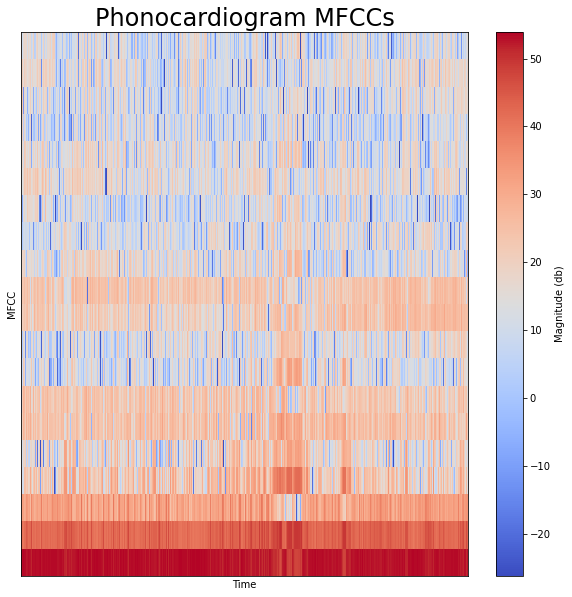

In [17]:
plt.figure(figsize=(10,10))
librosa.display.specshow(log_MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar(label='Magnitude (db)')
plt.title('Phonocardiogram MFCCs', size=24)
plt.savefig(fname=root_path + 'sample_MFCC.png')

Again, the 'loudness' in our graphical representation is clustered towards the bottom bins, the lower frequencies. We'll be taking this into consideration going forward. Next, we'll be diving into creating the data sets that we'll use for modelling.